# Transaction Fraud Solution Kit
### Leveraging Graph Features for Building ML Models for Fraud Detection

This tutorial showcases the power of graph features in predicting and preventing fraudulent transactions, which are part of the Transaction Fraud Solution Kit, a powerful tool developed by TigerGraph to solve your business problems with advanced graph and AI technologies. By integrating over 25 meticulously engineered graph features into your machine learning pipeline, you'll unlock new dimensions of data that significantly enhance existing ML models. Explore the **Features Documentation** for an in-depth look at how these features can be seamlessly calculated on your financial transaction graph. Prerequisites for this tutorial are working knowledge of TigerGraph database and experience on building ML models such as tree-based models.

Our journey begins with an exploration of a sample graph included in the Solution Kit, embodying transactions between credit cards and merchants, alongside cardholders ('Party') and their attributes such as addresses. For a visual guide and more details on our graph schema, please refer to our **Schema Documentation**.

Utilizing an XGBoost model, we will demonstrate the stark contrast in performance between models trained with and without our graph features. Here’s a glimpse of the empirical evidence highlighting the effectiveness of incorporating graph features:


| Model | Precision | Recall | 
|---------------------------------------------------|-----------------|-----------|
| XGBoost without Graph Features                    | 0.29    | 0.76 | 
| XGBoost with Graph Features                       | 0.34 (+5%)    | 0.78 (+2%) | 

The addition of graph features not only enhances precision by 5% but also improves recall by 2%, showcasing the capability of our graph-based approach to reduce false positives and increase the detection rate of fraudulent transactions. *This translates to significant cost savings and improved customer experience, as fewer legitimate transactions are falsely flagged as fraudulent.*

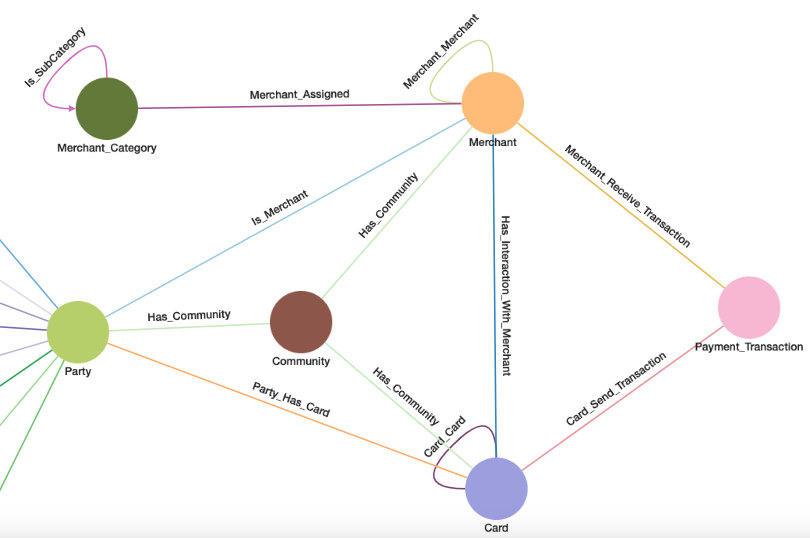  
Graph schema in the Transaction Fraud Solution Kit. Note: only the relevant part of the schema is shown in the figure.

## Data Preparation

### Connecting to the TigerGraph Database
First, we establish a connection to the TigerGraph database using the `TigerGraphConnection` class in the Python library `pyTigerGraph`, which acts as our portal for all interactions with the database. This step is crucial for accessing the robust features and data stored within TigerGraph. For a deeper dive into the functionalities provided by this class, visit the [pyTigerGraph documentation](https://docs.tigergraph.com/pytigergraph/current/intro/).

To connect to your specific database, kindly fill in your database's address, username and password.

In [1]:
from pyTigerGraph import TigerGraphConnection
   
conn = TigerGraphConnection(
    host="http://18.217.164.69",
    username="tigergraph",
    password="tigergraph",
    graphname="Transaction_Fraud"
)

If token authentication is not enabled for your database, you don't need to run the cell below. Note that token authentication is always enabled for TigerGraph Cloud databases.

In [2]:
# Skip if token authentication is not enabled for your database
conn.getToken();

Upon successfully connecting to your database, ensure the connection's integrity with a simple ping test. Subsequently, we embark on data retrieval, focusing on both fraudulent and normal transactions, thereby setting the stage for our predictive modeling.

In [3]:
# Check whether the connection is working
conn.ping()
# If successful, you should see the following message 
# `{'error': False, 'message': 'pong', 'results': None}`

{'error': False, 'message': 'pong', 'results': None}

### Pulling data from database 

With the database connection created above, we are going to pull relevant data for model training and testing. First, we do a quick check on the number of fraudulent transactions v.s. normal transactions. This can be easily achieved with the `getVertexCount` function.

Fraud transactions: 2201 (1.05%)
Normal transactions: 208388 (98.95%)


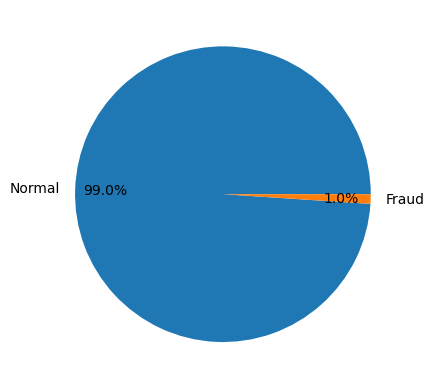

In [4]:
import matplotlib.pyplot as plt

frauds = conn.getVertexCount("Payment_Transaction", where="is_fraud = 1") 
nonfrauds = conn.getVertexCount("Payment_Transaction", where="is_fraud = 0") 
print("Fraud transactions: {} ({:.2f}%)".format(frauds, frauds/(frauds+nonfrauds)*100))
print("Normal transactions: {} ({:.2f}%)".format(nonfrauds, nonfrauds/(frauds+nonfrauds)*100))
plt.pie([nonfrauds, frauds],
        labels=["Normal", "Fraud"],
        autopct="%1.1f%%",
        pctdistance=0.8,
        explode=(0, 0));

Our dataset reveals a typical scenario in financial transactions: a significant class imbalance with fraud instances constituting a mere 1% of the data, underscoring the challenges in fraud detection. We will address this issue later in the modeling section.

We proceed by extracting all necessary transaction features and labels for model training. This can be done with the `getVertexDataFrame` function.

In [5]:
features = [
    "mer_com_size", "cd_com_size", "mer_pagerank", "cd_pagerank", "shortest_path_length",
    "max_txn_amt_interval", "max_txn_cnt_interval", "cnt_repeated_card", "com_mer_txn_cnt", "com_cd_txn_cnt",
    "com_mer_txn_total_amt", "com_cd_txn_total_amt", "com_mer_txn_avg_amt", "com_cd_txn_avg_amt",
    "com_mer_txn_max_amt", "com_cd_txn_max_amt", "com_mer_txn_min_amt", "com_cd_txn_min_amt",
    "mer_cat_cnt", "mer_cat_total_amt", "mer_cat_avg_amt", "mer_cat_max_amt", "mer_cat_min_amt",
    "indegree", "outdegree", "amount", "age", "city_pop", "gender"
]

labels = ["is_fraud"]

others = ["transaction_time"]

transactions = conn.getVertexDataFrame(
    "Payment_Transaction", 
    select=",".join(features+labels+others))

### Preprocessing data

We first check the data types and missing values. 

In [6]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210589 entries, 0 to 210588
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   v_id                   210589 non-null  object 
 1   mer_com_size           210589 non-null  int64  
 2   cd_com_size            210589 non-null  int64  
 3   mer_pagerank           210589 non-null  float64
 4   cd_pagerank            210589 non-null  float64
 5   shortest_path_length   210589 non-null  int64  
 6   max_txn_amt_interval   210589 non-null  int64  
 7   max_txn_cnt_interval   210589 non-null  int64  
 8   cnt_repeated_card      210589 non-null  int64  
 9   com_mer_txn_cnt        210589 non-null  int64  
 10  com_cd_txn_cnt         210589 non-null  int64  
 11  com_mer_txn_total_amt  210589 non-null  float64
 12  com_cd_txn_total_amt   210589 non-null  float64
 13  com_mer_txn_avg_amt    210589 non-null  float64
 14  com_cd_txn_avg_amt     210589 non-nu

Note that `gender` and `transaction_time` are not loaded in as numeric types, and hence we need to transform them so they can be used by a machine learning model.

In [7]:
from sklearn.preprocessing import LabelEncoder

# We just encode gender as 0's (female) and 1's (male).
encoder = LabelEncoder()
transactions["gender"] = encoder.fit_transform(transactions["gender"])

In [8]:
import pandas as pd

# Transaction time is not really a number, so we break it down to hour, day, and month 
# to see whether fraudulent transactions happen at certain times in a day.
transactions["transaction_time"] = pd.to_datetime(transactions["transaction_time"])
transactions['hour'] = transactions['transaction_time'].dt.hour
transactions['day'] = transactions['transaction_time'].dt.day
transactions['month'] = transactions['transaction_time'].dt.month

Sometimes, you might have domain knowledge on how fraudulent activities look like. Here we hypothesize that transactions whose amount are very different from what is normally spent with the merchant of the same category might be suspicious; hence, we add the following feature.

In [9]:
import numpy as np

# Recall `mer_cat_avg_amt` is the average transaction amount with merchants in the category.
transactions["extra_amount"]=np.log(transactions["amount"])-np.log(transactions["mer_cat_avg_amt"])

In [10]:
train_features = features +["extra_amount", "hour", "day", "month"]

### Train/test split

Before model training, it is common practice to split your data into training and testing sets and we are following that. As the names suggest, the training set will be used to train the model and the testing set to test its performance. 

Because transactions are temporal by nature, it makes more sense to split them based on time, so that we use "historical" data for training and "future" data for testing. If you split otherwise (e.g., random split), there is a risk that future information leaks into your training data and the model's performance might be overestimated.

Therefore, we first take a look at the distribution of transaction times for all transactions to find out where to make the cut.


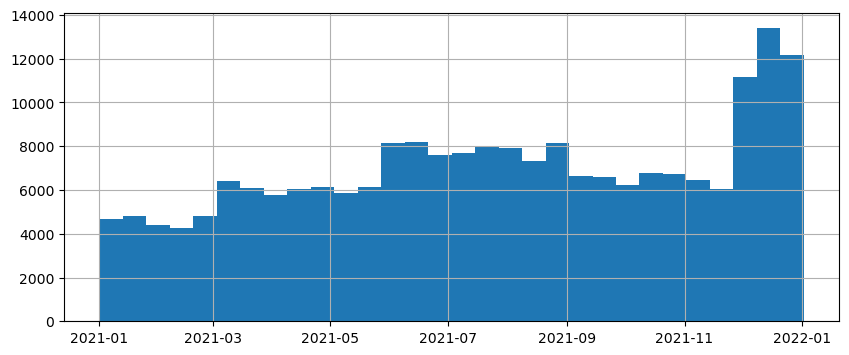

In [11]:
transactions.transaction_time.hist(bins=30, figsize=(10,4));

We also check the distribution of time for fraudulent transactions.

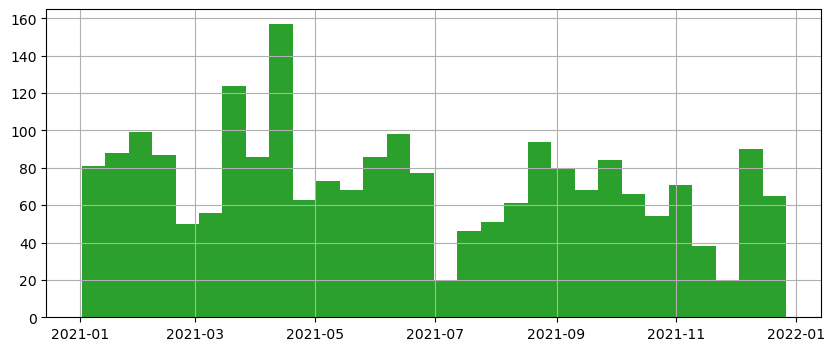

In [12]:
transactions.loc[transactions["is_fraud"]==1, "transaction_time"].hist(bins=30, figsize=(10,4), color="C2");

From the two distributions above, we can see that the numbers of transactions and fraudulent transactions are relatively spread out over time. Hence, we just use the last month of data for testing and all previous data for training. In other words, we use the date `2021-12-01` to split the transactions, and check their statistics quickly.

In [13]:
train_data = transactions[transactions.transaction_time<"2021-12-01"]
test_data = transactions[transactions.transaction_time>="2021-12-01"]

In [14]:
tmp = train_data.groupby("is_fraud").size()
print("Transactions in training set: {} ({:.2f}%)".format(
    len(train_data), len(train_data)/len(transactions)*100))
print("Fraud transactions in training set: {} ({:.2f}%)".format(tmp[1], tmp[1]/tmp.sum()*100))
print("Normal transactions in training set: {} ({:.2f}%)".format(tmp[0], tmp[0]/tmp.sum()*100))

Transactions in training set: 177251 (84.17%)
Fraud transactions in training set: 2034 (1.15%)
Normal transactions in training set: 175217 (98.85%)


In [15]:
tmp = test_data.groupby("is_fraud").size()
print("Transactions in testing set: {} ({:.2f}%)".format(
    len(test_data), len(test_data)/len(transactions)*100))
print("Fraud transactions in testing set: {} ({:.2f}%)".format(tmp[1], tmp[1]/tmp.sum()*100))
print("Normal transactions in testing set: {} ({:.2f}%)".format(tmp[0], tmp[0]/tmp.sum()*100))

Transactions in testing set: 33338 (15.83%)
Fraud transactions in testing set: 167 (0.50%)
Normal transactions in testing set: 33171 (99.50%)


## Model Training

Our model of choice, XGBoost, is renowned for its efficiency and performance across various domains. 

### Creating model

In [16]:
from xgboost import XGBClassifier, plot_importance

model = XGBClassifier(scale_pos_weight=10, n_estimators=50, learning_rate=0.1, max_depth=3) 

There are several hyperparameters for the XGBoost model as shown above. These hyperparameters influence the model's performance and behavior during the training process. But unfortunately there is no magic formula on how to set those numbers as they depend on the data and they cannot be learnt automatically. For how to tune those hyperparameters, please refer to the [official documentation of XGBoost](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html).

Here we highlight the hyperparameter `scale_pos_weight` which specifies how much weight to put on the positive cases (i.e., fraudulent transactions) in the cost function of the model. In other words, when the model is wrong about a positive case, the error should be reweighted by this number. This hyperparameter helps address the imbalanced label issue here. Because the number of fraudulent transactions is very small (about 1%), they should be weighted more or otherwise the model might ignore them and predict every case to be normal. Actually, if you predict every case to be normal, you are correct 99% of the time.

### Training model

In [17]:
model.fit(train_data[train_features], train_data["is_fraud"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Explaining Model

One big benefit of using the XGBoost model is its explainability, meaning that we can find out which features are more or less important for the model to make a prediction. We can visualize the feature importance with the following code. Note that there is no standard scale of the scores and they only make sense in a relative sense.

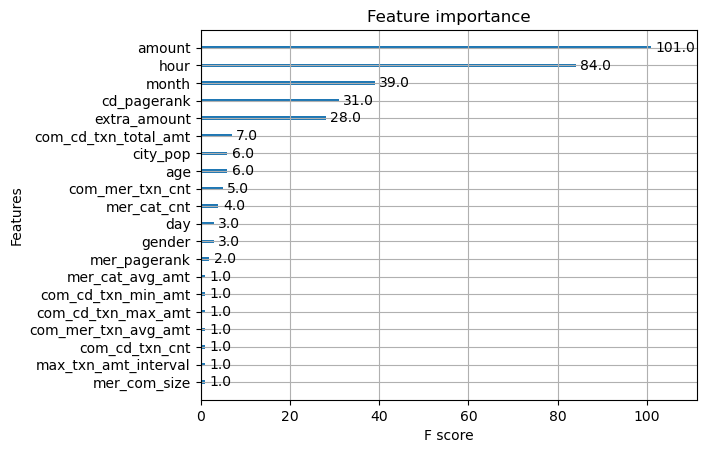

In [18]:
plot_importance(model);

We can see that the dollar `amount` of a transaction is the most important feature, which agrees with common sense. `hour` is the second most important feature, suggesting that the fraudulent transactions tend to happen at certain times of a day. The pagerank score of credit cards (`cd_pagerank`) ranks the 4th, demonstrating the power of graph features in identifying frauds. There are many other graph-based features showing up in the list and we will assess their effectiveness formally later. Before that, we should test the performance of this model on the testing set.

### Testing model

In [19]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay

def test(model, X, y):
    """Test the model's predictive performance on input X and groudtruth label y.
    
    Output 
    * A table of common metrics including precision, recall, accuracy and f1 scores
    * A plot of the consusion matrix
    * A plot of the precision recall curve
    
    """
    predictions = model.predict(X)
    probabilities = model.predict_proba(X)[:,1]
    print(classification_report(y, predictions))
    ConfusionMatrixDisplay.from_predictions(y, predictions);
    PrecisionRecallDisplay.from_predictions(y, probabilities);

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     33171
           1       0.34      0.78      0.47       167

    accuracy                           0.99     33338
   macro avg       0.67      0.89      0.73     33338
weighted avg       1.00      0.99      0.99     33338



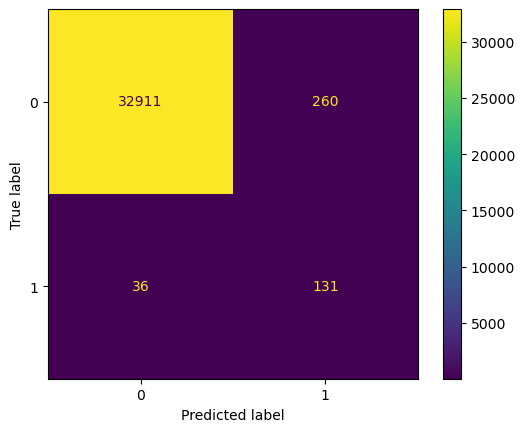

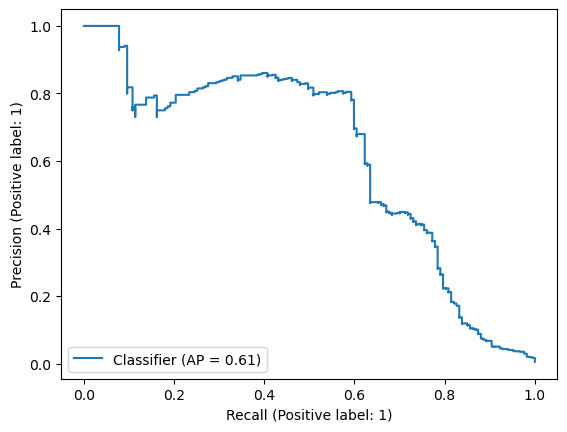

In [20]:
test(model, test_data[train_features], test_data["is_fraud"])

The model is able to achieve 78% recall and 34% precision in predicting fraud. The confusion matrix agrees with the numbers. From the Precision-Recall curve, we can see how precision trades with recall as we dial the model from more conservative to more aggressive, but it shows a good average-precision (AP=61%) overall.

## Performance Gain from Graph Features

To quantify the impact of graph features on our model's performance, we conduct a comparative analysis by training a baseline model without these features. The results are compelling, underscoring a notable decrease in precision and recall, thereby confirming the intrinsic value of graph features in enhancing the model's predictive capabilities.

We remove the graph features from our feature list, retrain the model, and test its performance.


In [21]:
non_graph_features = [
 'mer_cat_cnt',
 'mer_cat_total_amt',
 'mer_cat_avg_amt',
 'mer_cat_max_amt',
 'mer_cat_min_amt',
 'indegree',
 'outdegree',
 'amount',
 'age',
 'city_pop',
 'gender',
 'extra_amount',
 'hour',
 'day',
 'month']

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     33171
           1       0.29      0.76      0.42       167

    accuracy                           0.99     33338
   macro avg       0.65      0.88      0.71     33338
weighted avg       1.00      0.99      0.99     33338



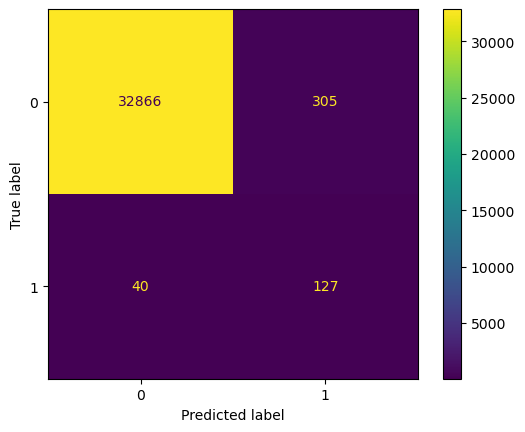

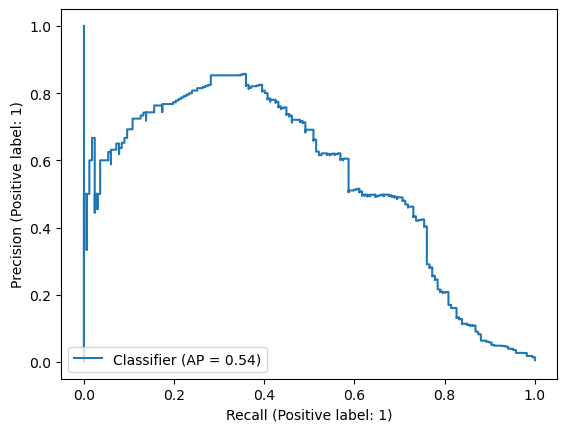

In [22]:
base_model = XGBClassifier(scale_pos_weight=10, n_estimators=50, learning_rate=0.1, max_depth=3)
base_model.fit(train_data[non_graph_features], train_data["is_fraud"])
test(base_model, test_data[non_graph_features], test_data["is_fraud"])

The testing result shows that the precision is dropped to 29% and recall is dropped to 76%. In other words, the graph features improve the model's precision by 5% and recall by 2%. The Average Precision for the Precision-Recall curve also witnesses a drop from 61% to 54%.

## Model Deployment

After the model is trained, we need to deploy it to the production (or the online testing) environment for real-time inference. The detailed steps would depend heavily on your model serving platform and vary from case to case. Below we demo two common approaches for completeness of this tutorial.

### Option 1: Save to local

The easist way is to save the trained model to a local file. Next, in a follow-up tutorial for model inference, we will demostrate how to load the model from the file and perform predictions for any given transaction. This also lays the foundation for more complex deployment methods.

In [24]:
model.save_model("xgboost_v1.json")

## Conclusion and Future Directions

Through this tutorial, we've demonstrated the unparalleled advantage of integrating graph features into fraud detection models. The addition of graph features not only enhances precision by 5% but also improves recall by 2%, showcasing the capability of our graph-based approach to reduce false positives and increase the detection rate of fraudulent transactions. This translates to significant cost savings and improved customer experience, as fewer legitimate transactions are falsely flagged as fraudulent. 

Ready to see the performance gain on your own transaction data? The Transaction Fraud Solution Kit from TigerGraph makes it easy. It provides an end-to-end solution to turn your data into valuable insights. For further guidance and additional resources, please visit **the entry point to solution kit**.

